In [1]:
%reload_ext tgpy
import tgpy as tg

# Data

In [2]:
df = tg.pd.read_pickle('~/Dropbox/Research/UOH/Tierras raras/Datos/tierras_raras.pkl')
filtro = df.Region == 'ANTOFAGASTA'
#filtro = df.Region == 'VALPARAISO'


inputs = ['Coord. N', 'Coord. E']
outputs = ['Pr(g/t)']
#outputs = ['Y(g/t)']
#outputs = ['Nd(g/t)']
#outputs = ['Dy(g/t)']
#outputs = ['Yb(g/t)']

dt = tg.DataTensor(df[filtro][inputs + outputs], inputs=inputs, outputs=outputs)
n = dt.ndata
dt

,Coord. N,Coord. E,Pr(g/t)
7,7190193.0,351515.0,50.02
15,7190110.0,351456.0,26.13
31,7160725.0,340194.0,8.55
33,7407014.0,393185.0,10.59
47,7327033.0,495795.0,8.96
...,...,...,...
2020,7308091.0,493083.0,0.43
2023,7188809.0,349758.0,0.41
2026,7308106.0,493100.0,0.42
2030,7222378.0,444925.0,0.33


In [3]:
df.groupby('Region').count()['IDQ']

Region
ANTOFAGASTA        92
ATACAMA           457
AYSEN              31
COQUIMBO         1118
MAULE               3
METROPOLITANA      66
OHIGGINS           33
TARAPACA           10
VALPARAISO        222
Name: IDQ, dtype: int64

In [4]:
dt.scale_inputs *= 0
dt.scale_inputs += 1000
#dt.shift_outputs *= 0
#dt.scale_outputs = 0 * dt.scale_outputs + 1

# Priors

In [5]:
dim = 100

In [6]:
high = 0.5
var_rq = tg.TgPrior('var_rq', ['o'], dim=dim, low=0, high=high, alpha=2, beta=4)
var_se = tg.TgPrior('var_se', ['o'], dim=dim, low=0, high=high, alpha=2, beta=4)
var_ou = tg.TgPrior('var_ou', ['o'], dim=dim, low=0, high=high, alpha=2, beta=4)
var_sinc = tg.TgPrior('var_sinc', ['o'], dim=dim, low=0, high=high, alpha=2, beta=4)
#var()

In [7]:
relevance = tg.TgPrior('relevance', ['x', 'y'], dim=dim, low=0.5, high=2, alpha=2, beta=4)
#relevance_se = tg.TgPrior('relevance_se', ['x', 'y'], dim=dim, low=0.5, high=2)
#relevance.p.x.data = relevance.p.x.data * 0.0 + 0.5
#relevance.p.y.data = relevance.p.y.data * 0.0 + 0.2
#relevance()

In [8]:
freedom = tg.TgPrior('freedom', ['o'], dim=dim, low=1, high=5, alpha=2, beta=4)
#freedom()

In [9]:
period = tg.TgPrior('period', ['x', 'y'], dim=dim, low=0.0, high=3, alpha=2, beta=4)

In [10]:
noise = tg.TgPrior('noise', ['o'], dim=dim, low=0.0, high=0.1, alpha=2, beta=4)
#noise()

In [11]:
shift = tg.TgPrior('shift', ['o'], dim=dim, low=-0.1, high=0, alpha=2, beta=4)
#shift()

In [12]:
power = tg.TgPrior('power', ['o'], dim=dim, low=0, high=1.2, alpha=2, beta=4)
#power()

# Model

In [13]:
kernel = tg.RQ(var_rq, relevance, freedom) #+ tg.SINC(var_sinc, relevance, period) + tg.SE(var_se, relevance) + tg.OU(var_ou, relevance)
cov = tg.CovarianceTransport(kernel, noise=tg.WN(noise))

In [14]:
marginal = tg.MarginalTransport(tg.BoxCoxShift(power, shift) )
positive = tg.MarginalTransport(tg.Relu())

In [15]:
tgp = tg.TGP([cov, marginal, positive], dt=dt)

# Cross-Validation

In [16]:
pobs = 0.8

nobs = int(pobs*n)
perm = tg.np.random.permutation(dt.index)
train = perm[:nobs]
valid = perm[nobs:]

train = dt.original_outputs(train).sort_values(by=dt.outputs).index.values
valid = dt.original_outputs(valid).sort_values(by=dt.outputs).index.values

# Learning

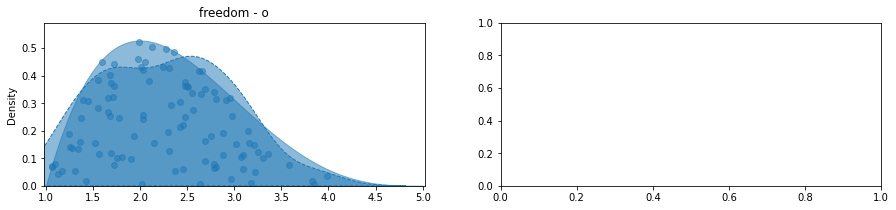

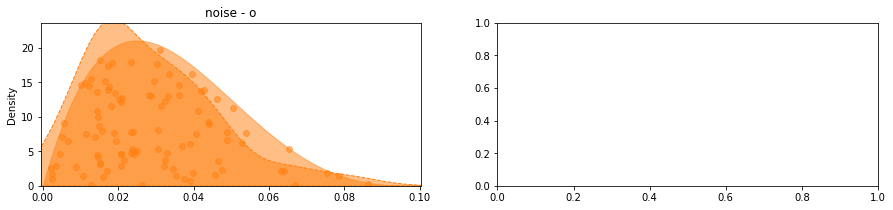

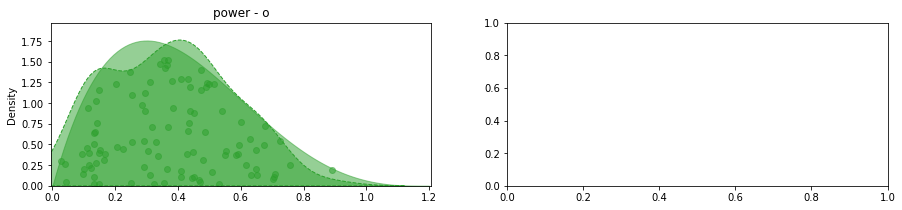

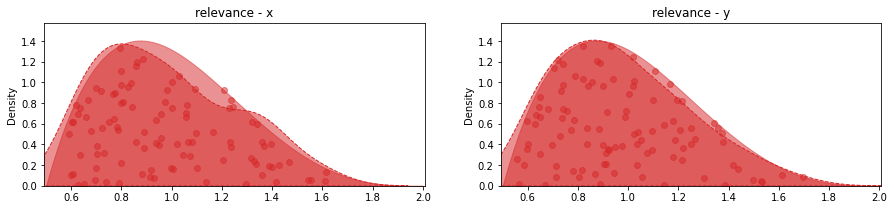

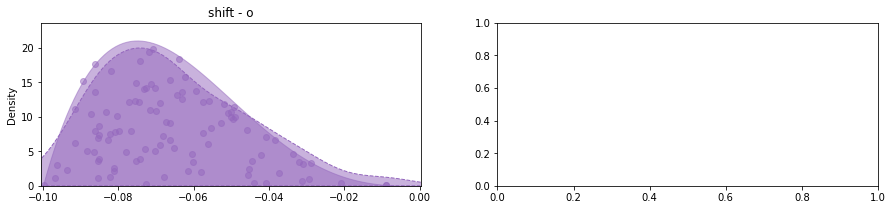

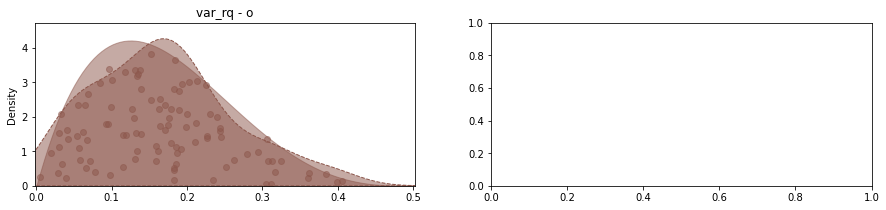

In [17]:
tgp.obs(index=train)
tgp.sample_priors()
tgp.plot_priors()

In [28]:
learning = tg.TgLearning(tgp, lr=0.001, pbatch=0.8, rand_pert=0.0, pot=0, cycle=0.1)
tgp.logp()

tensor([ -6813.9048,  -8493.4863,  -6938.4233, -10585.7490,  -7604.7446,
         -7280.5728,  -6513.9561,  -6616.8628,  -6715.1558, -10877.5371,
         -9409.4424,  -8761.6865,  -9130.5107, -12552.3496,  -6786.2261,
         -6141.9238,  -7329.7930, -10037.4990,  -7571.1445,  -7122.2251,
         -6341.0029,  -6652.9551,  -6160.7637, -14162.4434,  -6129.1616,
         -7308.4683, -12558.6650,  -9485.4414,  -6786.7432,  -6609.8838,
         -7306.5884, -10670.3252,  -6805.2173,  -6851.3330,  -8240.8555,
        -11077.9492,  -7791.6934,  -8017.5464,  -7469.1968,  -7160.1533,
         -6252.8105,  -7961.8481,  -6775.3047,  -7715.0781,  -7134.5288,
         -6740.3174,  -6744.3867,  -6804.1982,  -7432.8232,  -7235.8760,
         -6537.3921,  -6241.8667,  -7407.5654, -14916.9814,  -9605.6885,
        -10159.7725,  -8161.9756, -11563.6973, -13758.0674,  -7250.5488,
         -7389.6670,  -6517.3735,  -8007.7041,  -7386.3076,  -6695.7676,
         -8076.2173,  -9405.6191,  -6756.5391, -108

  0%|                                                                                                         …

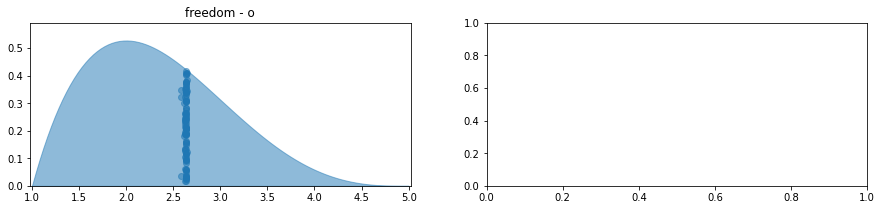

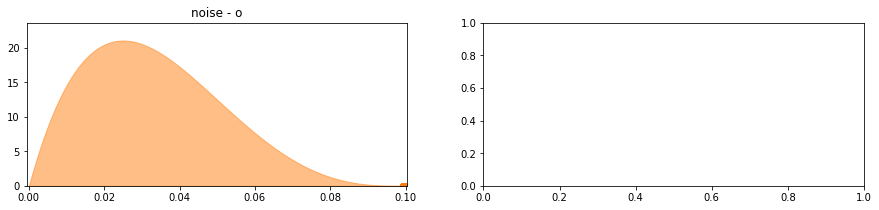

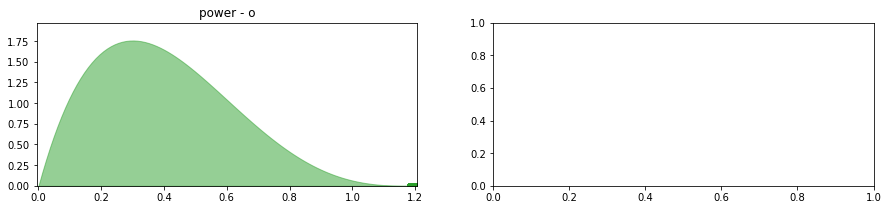

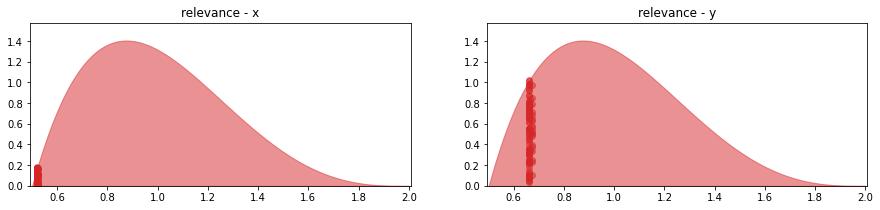

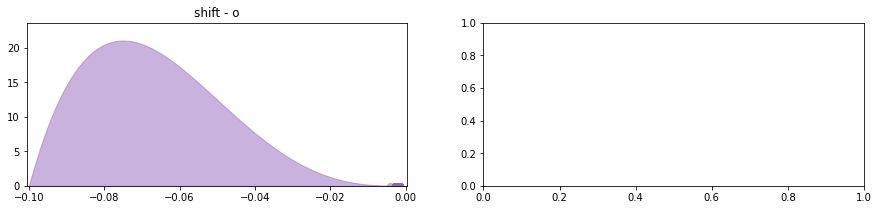

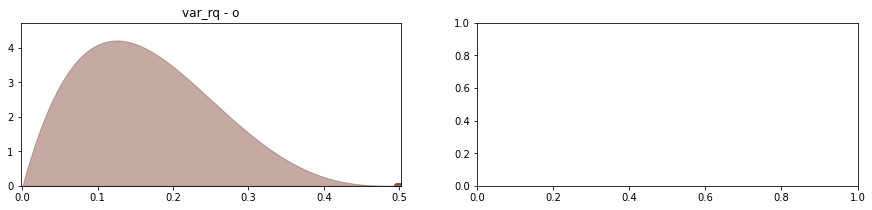

In [30]:
learning.execute_sgd(1000)
tgp.plot_priors(kde=False)

  0%|                                                                                                         …

/home/grios/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:197: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [100], strides() = [7]
param.sizes() = [100], strides() = [1] (Triggered internally at ../torch/csrc/autograd/functions/accumulate_grad.h:202.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


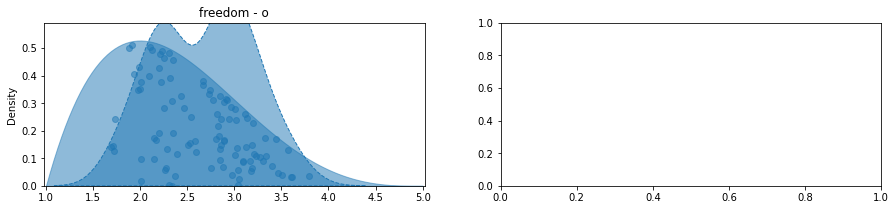

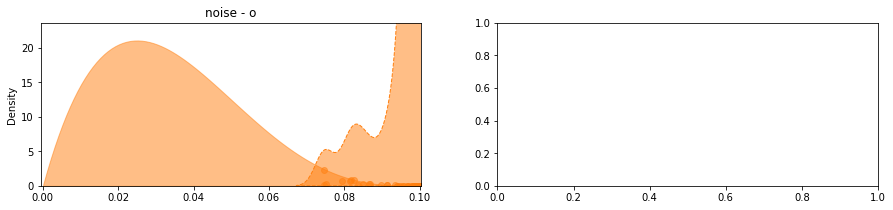

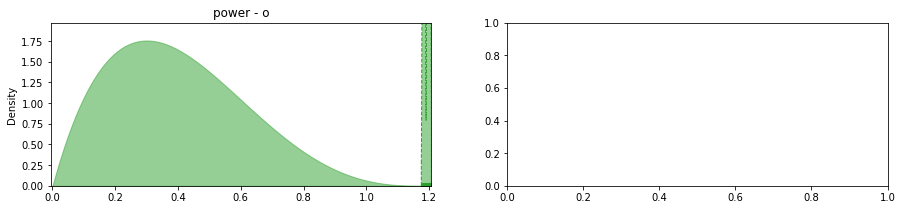

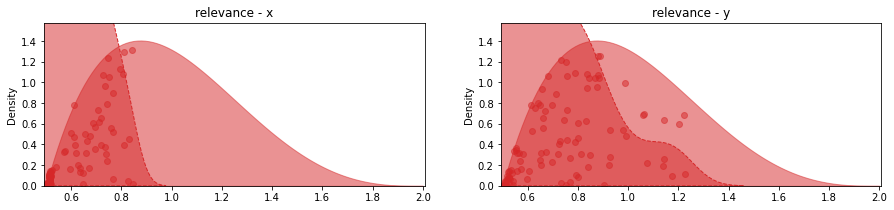

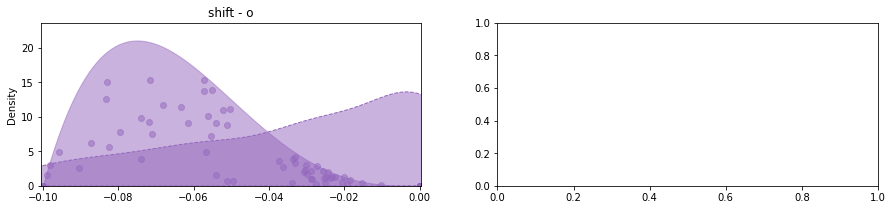

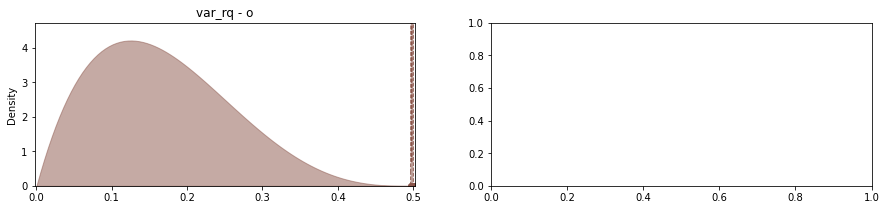

In [31]:
learning.execute_svgd(1000)
tgp.plot_priors(kde=True)

# Eval

In [32]:
dt.original_inputs(valid)

,Coord. N,Coord. E
2020,7308091.0,493083.0
1654,7521846.0,519169.0
1354,7189175.0,354192.0
966,7464137.0,464142.0
717,7466009.0,465702.0
678,7190910.0,351844.0
501,7190993.0,351821.0
586,7463313.0,464841.0
491,7468505.0,466605.0
431,7464120.0,464168.0


In [33]:
quantiles = 0.3
pred, samples = tgp.predict(dt.original_inputs(valid), quantiles=quantiles, nsamples=1000, samples=True, noise=True)
pred

,Coord. N,Coord. E,Median,Mean,Quantile 70,Quantile 30,Interval,Certainty
2020,7308091.0,493083.0,2.305561,2.694833,3.916319,0.330000,3.586319,0.407151
1654,7521846.0,519169.0,6.873639,7.003531,9.520751,4.230994,5.289757,0.125559
1354,7189175.0,354192.0,4.253673,4.270913,5.775486,2.839702,2.935783,0.514690
966,7464137.0,464142.0,6.499190,6.571659,9.269314,3.477480,5.791834,0.042561
717,7466009.0,465702.0,4.536916,4.543303,6.089696,2.827830,3.261867,0.460786
678,7190910.0,351844.0,2.977352,3.190454,4.558713,1.526426,3.032287,0.498738
501,7190993.0,351821.0,3.789900,3.863135,5.180500,2.358870,2.821630,0.533561
586,7463313.0,464841.0,4.570151,4.478379,5.930410,2.937182,2.993228,0.505194
491,7468505.0,466605.0,6.937807,7.090425,9.653260,4.103101,5.550158,0.082512
431,7464120.0,464168.0,6.521777,6.594494,9.223784,3.539930,5.683854,0.060411


In [34]:
#to_eval = train
to_eval = valid

real = dt.original_outputs(to_eval)[dt.outputs[0]]

In [35]:
quantiles = 0.6 # 0.5 - 1.0
pred, samples = tgp.predict(to_eval, quantiles=quantiles, nsamples=1000, samples=True, noise=True)
pred

,Coord. N,Coord. E,Pr(g/t),Median,Median Error,Mean,Mean Error,Quantile 40,Quantile 60,Interval,Certainty
2020,7308091.0,493083.0,0.43,2.254222,-1.824222,2.524918,-2.094918,1.188899,2.874332,-1.685433,-0.554812
1654,7521846.0,519169.0,2.19,6.789898,-4.599898,6.891820,-4.701820,5.349566,8.103238,-2.753672,-1.540263
1354,7189175.0,354192.0,2.85,4.007692,-1.157692,4.059088,-1.209088,3.269206,4.848257,-1.579051,-0.456675
966,7464137.0,464142.0,3.66,6.679344,-3.019344,6.859776,-3.199776,5.390574,8.108265,-2.717691,-1.507070
717,7466009.0,465702.0,4.15,4.494849,-0.344849,4.528598,-0.378598,3.640152,5.304038,-1.663886,-0.534935
678,7190910.0,351844.0,4.47,2.986005,1.483995,3.083755,1.386245,2.234968,3.669184,-1.434216,-0.323065
501,7190993.0,351821.0,4.78,3.685310,1.094690,3.730020,1.049980,2.931112,4.386714,-1.455602,-0.342793
586,7463313.0,464841.0,4.78,4.394604,0.385396,4.367616,0.412384,3.788240,4.965156,-1.176916,-0.085705
491,7468505.0,466605.0,4.93,6.964838,-2.034838,7.044747,-2.114747,5.560492,8.295512,-2.735020,-1.523057
431,7464120.0,464168.0,5.04,6.834164,-1.794164,6.930917,-1.890917,5.246275,8.286254,-3.039979,-1.804382


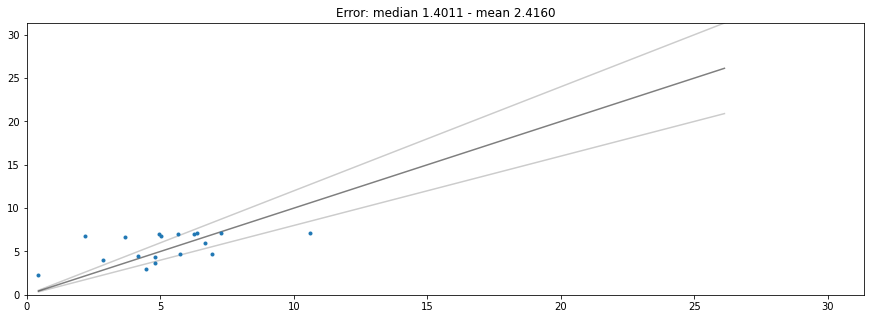

In [36]:
tg.plt.figure(figsize=(15,5))

tg.plot2d(real, real, color='k', alpha=0.5)
tg.plot2d(real, real * (1.2), color='k', alpha=0.2)
tg.plot2d(real, real * (0.8), color='k', alpha=0.2)

#tg.plot2d(dt.tensor_outputs[valid, 0], (pred.nanmean(dim=0) + pred.nanmedian(dim=0).values)/2, linestyle='None', marker='.')
#tg.plot2d(real, pred.mean(),linestyle='None', marker='.')
tg.plot2d(real, pred['Median'],linestyle='None', marker='.')

tg.plt.xlim([0,real.max()*1.2])
tg.plt.ylim([0,real.max()*1.2])
tg.plt.title('Error: median %.4f - mean %.4f' % (pred['Median Error'].abs().median(), pred['Mean Error'].abs().mean()));

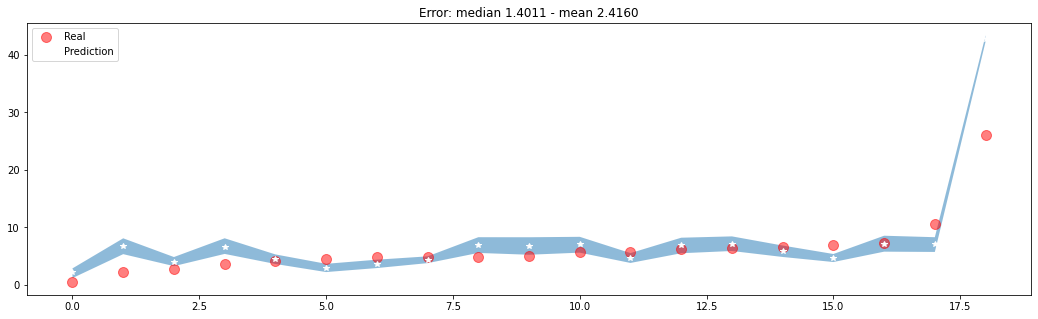

In [37]:
ax = tg.plt.subplots(figsize=(18,5))

tg.plot2d(real, color='r', alpha=0.5, linestyle='None', marker='.', ms=20, label='Real')
tg.plot2d(pred['Median'], linestyle='None', marker='*', color='white', label='Prediction')
#tg.plot2d(pred.mean(), linestyle='None', marker='*', color='k', label='Prediction')


tg.plt.fill_between(tg.np.arange(len(real)), pred['Quantile '+str(int(100*(1-quantiles)))], pred['Quantile '+str(int(100*quantiles))], alpha=0.5)

#tg.sb.violinplot(data=pred, inner='quartile', scale='count')
#tg.plt.ylim([0, real.max()+2])
tg.plt.legend()
tg.plt.title('Error: median %.4f - mean %.4f' % (pred['Median Error'].abs().median(), pred['Mean Error'].abs().mean()));

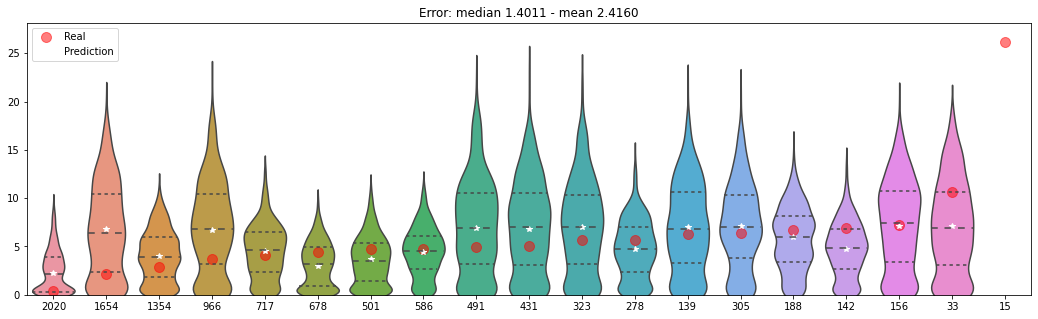

In [38]:
ax = tg.plt.subplots(figsize=(18,5))

tg.plot2d(real, color='r', alpha=0.5, linestyle='None', marker='.', ms=20, label='Real')
tg.plot2d(pred['Median'], linestyle='None', marker='*', color='white', label='Prediction')

tg.sb.violinplot(data=samples.sample(1000), inner='quartile', scale='count')
tg.plt.ylim([0, real.max()+2])
tg.plt.legend()
tg.plt.title('Error: median %.4f - mean %.4f' % (pred['Median Error'].abs().median(), pred['Mean Error'].abs().mean()));

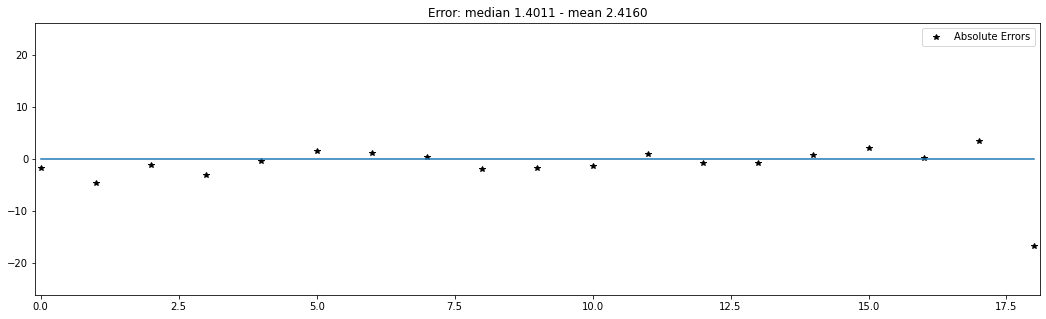

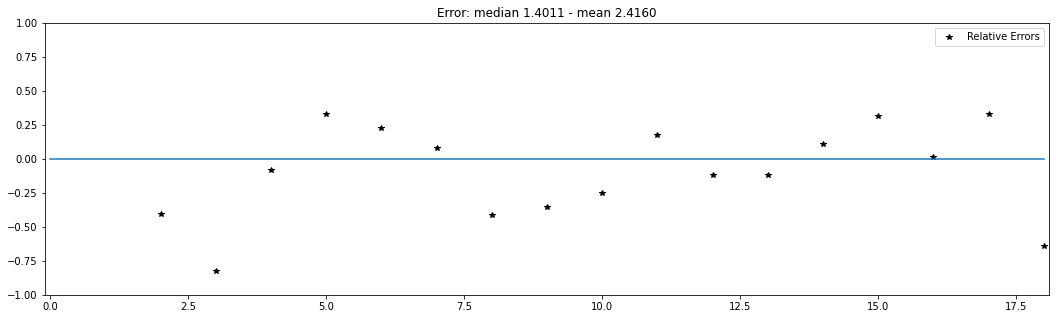

In [39]:
ax = tg.plt.subplots(figsize=(18,5))

tg.plot2d((pred['Median Error']), linestyle='None', marker='*', color='k', label='Absolute Errors')
tg.plot2d(0 * real)
tg.plt.legend()
tg.plt.xlim([-0.1, len(to_eval)-0.9])
tg.plt.ylim([-real.max(), real.max()])
tg.plt.title('Error: median %.4f - mean %.4f' % (pred['Median Error'].abs().median(), pred['Mean Error'].abs().mean()));

ax = tg.plt.subplots(figsize=(18,5))
tg.plot2d(pred['Median Error']/real, linestyle='None', marker='*', color='k', label='Relative Errors')
tg.plot2d(0 * real)
tg.plt.legend()
tg.plt.xlim([-0.1, len(to_eval)-0.9])
tg.plt.ylim([-1, 1])
tg.plt.title('Error: median %.4f - mean %.4f' % (pred['Median Error'].abs().median(), pred['Mean Error'].abs().mean()));

In [40]:
pred

,Coord. N,Coord. E,Pr(g/t),Median,Median Error,Mean,Mean Error,Quantile 40,Quantile 60,Interval,Certainty
2020,7308091.0,493083.0,0.43,2.254222,-1.824222,2.524918,-2.094918,1.188899,2.874332,-1.685433,-0.554812
1654,7521846.0,519169.0,2.19,6.789898,-4.599898,6.891820,-4.701820,5.349566,8.103238,-2.753672,-1.540263
1354,7189175.0,354192.0,2.85,4.007692,-1.157692,4.059088,-1.209088,3.269206,4.848257,-1.579051,-0.456675
966,7464137.0,464142.0,3.66,6.679344,-3.019344,6.859776,-3.199776,5.390574,8.108265,-2.717691,-1.507070
717,7466009.0,465702.0,4.15,4.494849,-0.344849,4.528598,-0.378598,3.640152,5.304038,-1.663886,-0.534935
678,7190910.0,351844.0,4.47,2.986005,1.483995,3.083755,1.386245,2.234968,3.669184,-1.434216,-0.323065
501,7190993.0,351821.0,4.78,3.685310,1.094690,3.730020,1.049980,2.931112,4.386714,-1.455602,-0.342793
586,7463313.0,464841.0,4.78,4.394604,0.385396,4.367616,0.412384,3.788240,4.965156,-1.176916,-0.085705
491,7468505.0,466605.0,4.93,6.964838,-2.034838,7.044747,-2.114747,5.560492,8.295512,-2.735020,-1.523057
431,7464120.0,464168.0,5.04,6.834164,-1.794164,6.930917,-1.890917,5.246275,8.286254,-3.039979,-1.804382


In [41]:
dt

,Coord. N,Coord. E,Pr(g/t)
7,7190193.0,351515.0,50.02
15,7190110.0,351456.0,26.13
31,7160725.0,340194.0,8.55
33,7407014.0,393185.0,10.59
47,7327033.0,495795.0,8.96
...,...,...,...
2020,7308091.0,493083.0,0.43
2023,7188809.0,349758.0,0.41
2026,7308106.0,493100.0,0.42
2030,7222378.0,444925.0,0.33
